<a href="https://colab.research.google.com/github/SvetlanaTsim/recommendation_systems/blob/main/lesson_06/hw6_recsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Урок 6. Двухуровневые модели рекомендаций

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?


In [1]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.1/310.1 KB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.16-cp38-cp38-linux_x86_64.whl size=916410 sha256=a901f1d37af680a045f2c8602f68076b3eca4aa21202ff117efa788928920afd
  Stored in directory: /root/.cache/pip/wheels/ec/bb/51/9c487d021c1373b691d13cadca0b65b6852627b1f3f43550fa
Successfully built lightfm


In [2]:
!pip install implicit==0.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for implicit: filename=implicit-0.4.4-cp38-cp38-linux_x86_64.whl size=5259121 sha256=aeb681976081e5892312ac432a34080efc6bf16cccc04e869cf429a33c6e9344
  Stored in directory: /root/.cache/pip/wheels/00/ac/67/6f4536c819ed560c2c7e17c0f7a920e3e50c26108616087d05
Successfully built implicit


In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.4 MB/s eta 0:00:00


In [4]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

In [6]:
# Ignore some warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
#metrics

"""
Metrics for RecSys
"""
import numpy as np


def hit_rate(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(bought_list, recommended_list)
    return (flags.sum() > 0) * 1


def hit_rate_at_k(recommended_list, bought_list, k=5):
    return hit_rate(recommended_list[:k], bought_list)


def precision(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(bought_list, recommended_list)
    return flags.sum() / len(recommended_list)


def precision_at_k(recommended_list, bought_list, k=5):
    return precision(recommended_list[:k], bought_list)


def money_precision_at_k(recommended_list, bought_list, prices_recommended, k=5):
    recommended_list = np.array(recommended_list)[:k]
    prices_recommended = np.array(prices_recommended)[:k]
    flags = np.isin(recommended_list, bought_list)
    return np.dot(flags, prices_recommended).sum() / prices_recommended.sum()


def recall(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(bought_list, recommended_list)
    return flags.sum() / len(bought_list)


def recall_at_k(recommended_list, bought_list, k=5):
    return recall(recommended_list[:k], bought_list)


def money_recall_at_k(recommended_list, bought_list, prices_recommended, prices_bought, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]
    prices_recommended = np.array(prices_recommended)[:k]
    prices_bought = np.array(prices_bought)
    flags = np.isin(recommended_list, bought_list)
    return np.dot(flags, prices_recommended).sum() / prices_bought.sum()


def ap_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    recommended_list = recommended_list[recommended_list <= k]

    relevant_indexes = np.nonzero(np.isin(recommended_list, bought_list))[0]
    if len(relevant_indexes) == 0:
        return 0
    amount_relevant = len(relevant_indexes)


    sum_ = sum(
        [precision_at_k(recommended_list, bought_list, k=index_relevant + 1) for index_relevant in relevant_indexes])
    return sum_ / amount_relevant

In [8]:
# #utils

"""
Filters for RecSys
"""

import pandas as pd
import numpy as np


def prefilter_items(data, take_n_popular=5000, item_features=None):
    """Prefilter items and take top popular"""

    # Delete rare categories (department)
    if item_features is not None:
        department_size = pd.DataFrame(item_features. \
                                       groupby('department')['item_id'].nunique(). \
                                       sort_values(ascending=False)).reset_index()

        department_size.columns = ['department', 'n_items']
        rare_departments = department_size[department_size['n_items'] < 150].department.tolist()
        items_in_rare_departments = item_features[
            item_features['department'].isin(rare_departments)].item_id.unique().tolist()

        data = data[~data['item_id'].isin(items_in_rare_departments)]

    # Delete cheap items (non profit). Price one purchase from mailing is 1 dollar
    data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
    data = data[data['price'] > 2]

    # Delete expensive items
    data = data[data['price'] < 50]

    # Get top popular items
    popularity = data.groupby('item_id')['quantity'].sum().reset_index()
    popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
    top = popularity.sort_values('n_sold', ascending=False).head(take_n_popular).item_id.tolist()

    # Set a fake id for non popular items
    data.loc[~data['item_id'].isin(top), 'item_id'] = 999999

    return data


def postfilter_items(user_id, recommednations):
    """Postfilter items after fit models"""

    # What time to show?
    # How often to show?
    pass

In [9]:
#MainRecommender

"""
Baseline for RecSys
"""
import pandas as pd
import numpy as np


# For sparse matrix
from scipy.sparse import csr_matrix


# Matrix factorization
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # for own recommend
from implicit.nearest_neighbours import bm25_weight, tfidf_weight


class MainRecommender:
    """
    Baseline
    Get base recomendations from ALS or k-nearest algorithms
    Input
    -----
    user_item_matrix: pd.DataFrame
        Matrix user-item conversations
    """

    def __init__(self, data: pd.DataFrame, weighting: bool = True):

        # Top popular purchases of each user
        self.top_purchases = data.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
        self.top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.top_purchases = self.top_purchases[self.top_purchases['item_id'] != 999999]

        # Top popular purchases of all dataset
        self.overall_top_purchases = data.groupby('item_id')['quantity'].count().reset_index()
        self.overall_top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.overall_top_purchases = self.overall_top_purchases[self.overall_top_purchases['item_id'] != 999999]
        self.overall_top_purchases = self.overall_top_purchases.item_id.tolist()

        # Get sparse matrix
        self.user_item_matrix = self._prepare_matrix(data)  # pd.DataFrame
        
        # Get user-item ids map dictionary
        self.id_to_itemid, self.id_to_userid, \
        self.itemid_to_id, self.userid_to_id = self._prepare_dicts(self.user_item_matrix)

        # Weighting matrix for better result
        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T

        # Learn two type of models
        self.model = self.fit(self.user_item_matrix)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)

    @staticmethod
    def _prepare_matrix(data: pd.DataFrame):
        """Prepare sparse user-item matrix"""
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id',
                                          columns='item_id',
                                          values='quantity',  # variable
                                          aggfunc='count',
                                          fill_value=0
                                          )

        user_item_matrix = user_item_matrix.astype(float)  # necessary matrix type for implicit 

        return user_item_matrix

    @staticmethod
    def _prepare_dicts(user_item_matrix):
        """Prepare ids dictionaries"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id

    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Learn model that get item recommendations among user's purchases"""

        own_recommender = ItemItemRecommender(K=1, num_threads=4)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())

        return own_recommender

    @staticmethod
    def fit(user_item_matrix, n_factors=20, regularization=0.001, iterations=15, num_threads=4):
        """Learn ALS"""

        model = AlternatingLeastSquares(factors=n_factors,
                                        regularization=regularization,
                                        iterations=iterations,
                                        num_threads=num_threads)
        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        return model

    def _update_dict(self, user_id):
        """Update dicts if new user/item has added"""

        if user_id not in self.userid_to_id.keys():
            max_id = max(list(self.userid_to_id.values()))
            max_id += 1

            self.userid_to_id.update({user_id: max_id})
            self.id_to_userid.update({max_id: user_id})

    def _get_similar_item(self, item_id):
        """Find new similar item to item_id"""

        # Get two recs and choose only second because first is self item_id
        recs = self.model.similar_items(self.itemid_to_id[item_id], N=2)  
        top_rec = recs[1][0]
        return self.id_to_itemid[top_rec]

    def _extend_with_top_popular(self, recommendations, N=5):
        """Extend recs with top popular if num of items less than N"""

        if len(recommendations) < N:
            recommendations.extend(self.overall_top_purchases[:N])
            recommendations = recommendations[:N]

        return recommendations

    def _get_recommendations(self, user, model, N=5):
        """Get top-N recommendations from standart algorithms of implicit lib"""

        self._update_dict(user_id=user)
        res = [self.id_to_itemid[rec[0]] for rec in model.recommend(userid=self.userid_to_id[user],
                                                                    user_items=csr_matrix(
                                                                        self.user_item_matrix).tocsr(),
                                                                    N=N,
                                                                    filter_already_liked_items=False,
                                                                    filter_items=[self.itemid_to_id[999999]],
                                                                    recalculate_user=True)]

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Number of recommendations != {}'.format(N)
        return res

    def get_als_recommendations(self, user, N=5):       
        """Get top-N ALS recommendations"""

        return self._get_recommendations(user, model=self.model, N=N)

    def get_own_recommendations(self, user, N=5):
        """Get top-N own item recommendations among user's purchases"""

        return self._get_recommendations(user, model=self.own_recommender, N=N)

    def get_similar_items_recommendation(self, user_id, N=5):
        """Get top-N items similar to user's top popular self purchases"""

        top_users_purchases = self.top_purchases[self.top_purchases['user_id'] == user_id].head(N)

        res = top_users_purchases['item_id'].apply(lambda x: self._get_similar_item(x)).tolist()
        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Number of recommendations != {}'.format(N)
        return res

    def get_similar_users_recommendation(self, user_id, N=5):
        """Get top-N items among similar users purchases"""

        res = []

        # Find top-N similar users (get it with 10 reserve users)
        similar_users = self.model.similar_users(self.userid_to_id[user_id], N=N + 11)
        similar_users = [self.id_to_userid[rec[0]] for rec in similar_users]
        similar_users = similar_users[1:]  # delete self user's id from query

        # Get one own recommendation for each similar user
        for _user_id in similar_users:
            _rec = self.get_own_recommendations(_user_id, N=1)
            # add only unique item
            if _rec not in res:
                res.extend(_rec)

        # Cut if redundand
        res = res[:N]

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Number of recommendations != {}'.format(N)
        return res

In [21]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [22]:
# timeline for train:  -- old purchases -- | -- 6 weeks -- 

VAL_MATCHER_WEEKS = 6

In [23]:
# data for train 1-st layer model (matching)     -- old purchases --
data_train_matcher = data_train_lvl_1

# data for validate 1-st layer model (matching)  -- 6 weeks --
data_val_matcher = data_val_lvl_1

# data for train 2-nd layer model (ranking)      -- 6 weeks --
data_train_ranker = data_train_lvl_2

# data for validate 2-nd layer model (ranking)   -- 3 weeks (test data) --
data_val_ranker = data_val_lvl_2

In [24]:
def print_stats_data(df_data, name_df):
    print(f'{name_df}:')
    print(f"Shape: {df_data.shape} Users: {df_data['user_id'].nunique()} Items: {df_data['item_id'].nunique()}\n")

In [25]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher:
Shape: (2108779, 12) Users: 2498 Items: 83685

val_matcher:
Shape: (169711, 12) Users: 2154 Items: 27649

train_ranker:
Shape: (169711, 12) Users: 2154 Items: 27649

val_ranker:
Shape: (118314, 12) Users: 2042 Items: 24329



In [26]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [27]:
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher:
Shape: (861404, 13) Users: 2495 Items: 5001

val_matcher:
Shape: (169615, 12) Users: 2151 Items: 27644

train_ranker:
Shape: (169615, 12) Users: 2151 Items: 27644

val_ranker:
Shape: (118282, 12) Users: 2040 Items: 24325



In [28]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [29]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1090931, 1116376, 1106523, 871756]

In [30]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [31]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 937292, 824758, 902172]

In [32]:
recommender.get_similar_users_recommendation(2375, N=5)

[1097398, 935578, 1055403, 7146026, 929410]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

In [33]:
result_eval_matcher = data_val_matcher.groupby('user_id')['item_id'].unique().reset_index()
result_eval_matcher.columns=['user_id', 'actual']
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [34]:
N_PREDICT = 50 

In [35]:
%%time

result_eval_matcher['own_rec'] = result_eval_matcher['user_id'].\
                                    apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

result_eval_matcher['sim_item_rec'] = result_eval_matcher['user_id'].\
                                    apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))

result_eval_matcher['als_rec'] = result_eval_matcher['user_id'].\
                                    apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

result_eval_matcher['top_rec'] = result_eval_matcher['user_id'].\
                                    apply(lambda x: recommender.overall_top_purchases[:N_PREDICT])

CPU times: user 50 s, sys: 32.7 s, total: 1min 22s
Wall time: 52.5 s


In [36]:
result_eval_matcher.head(2)

,user_id,actual,own_rec,sim_item_rec,als_rec,top_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 1007512, 9297615, 5577022, 1132231, 9...","[9834742, 856942, 865026, 1134296, 9655212, 11...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090509, 5569845, 1044078, 985999, 880888, 81...","[5569230, 5569845, 5570048, 1017369, 874972, 5...","[1029743, 1106523, 5569230, 916122, 844179, 10..."


In [37]:
def calc_recall(df_data, top_k=50):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

In [38]:
def calc_precision(df_data, top_k=5):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.\
                            apply(lambda row: precision_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

In [39]:
TOPK_RECALL = 50

In [40]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1], reverse=True)

[('own_rec', 0.06525657038145165),
 ('als_rec', 0.053602170495126784),
 ('top_rec', 0.0432368435310526),
 ('sim_item_rec', 0.038436271709618636)]

**Вывод**

Наилучшим оказался ItemItemRecommender на к=50.

**Найдём наилучшие K для recall**

In [41]:
top_k_recs = [20, 50, 100, 200, 500, 750, 1000, 1500, 2000]

In [42]:
%%time

for k in top_k_recs:
    name_col = 'own_rec_' + str(k)
    result_eval_matcher[name_col] = result_eval_matcher['user_id'].\
                                        apply(lambda x: recommender.get_own_recommendations(x, N = k))

CPU times: user 52.1 s, sys: 2.1 ms, total: 52.1 s
Wall time: 52.1 s


In [43]:
result_eval_matcher.head(2)

,user_id,actual,own_rec,sim_item_rec,als_rec,top_rec,own_rec_20,own_rec_50,own_rec_100,own_rec_200,own_rec_500,own_rec_750,own_rec_1000,own_rec_1500,own_rec_2000
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 1007512, 9297615, 5577022, 1132231, 9...","[9834742, 856942, 865026, 1134296, 9655212, 11...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[856942, 9297615, 5577022, 877391, 9655212, 88..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090509, 5569845, 1044078, 985999, 880888, 81...","[5569230, 5569845, 5570048, 1017369, 874972, 5...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[911974, 1076580, 1103898, 5567582, 1056620, 9..."


Посчитаем recall для каждого k

In [44]:
own_recalls = []

for k in top_k_recs:
    name_col = 'own_rec_' + str(k)
    own_recalls.append(*(calc_recall(result_eval_matcher[['user_id', 'actual', name_col]], k)))

own_recalls = sorted(own_recalls, key=lambda x: x[1], reverse=True)
own_recalls

[('own_rec_2000', 0.2540542627215496),
 ('own_rec_1500', 0.23898784772021117),
 ('own_rec_1000', 0.21679061833967841),
 ('own_rec_750', 0.20041247093594675),
 ('own_rec_500', 0.18205324555508703),
 ('own_rec_200', 0.13537278412833254),
 ('own_rec_100', 0.09604492955885016),
 ('own_rec_50', 0.06525657038145165),
 ('own_rec_20', 0.039284276793729055)]

In [45]:
own_recalls_k = []
for rec in own_recalls[::-1]:
    own_recalls_k.append(rec[1])
own_recalls_k

[0.039284276793729055,
 0.06525657038145165,
 0.09604492955885016,
 0.13537278412833254,
 0.18205324555508703,
 0.20041247093594675,
 0.21679061833967841,
 0.23898784772021117,
 0.2540542627215496]

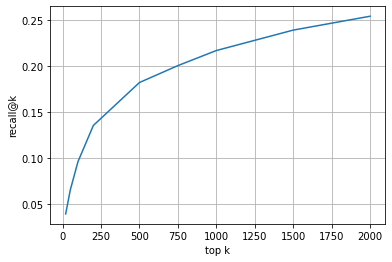

In [46]:
plt.plot(top_k_recs, own_recalls_k)
plt.grid()
plt.xlabel('top k')
plt.ylabel('recall@k')
plt.show()

Наиболее сильно recall увеличивается до k=200. Далее темпы роста снижаются.
Поэтому мы примем k=200.

In [47]:
N_PREDICT = 200

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [90]:
# make prefiltered data
data_val_matcher = prefilter_items(data_val_matcher, item_features=item_features, take_n_popular=5000)


In [91]:
# make joined dataset from 1-st layer (matching)  -- old weeks + 6 weeks --
df_join_train_matcher = pd.concat([data_train_matcher, data_val_matcher])

In [92]:
df_join_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.4,1642,1,0.0,0.0,2.99
11,1364,26984896261,1,999999,1,2.19,31742,0.0,1520,1,0.0,0.0,2.19


In [93]:
# возьмем только уникальных users из train_ranker -- 6 weeks --
df_match_candidates = pd.DataFrame(df_join_train_matcher['user_id'].unique())
df_match_candidates.columns = ['user_id']

In [94]:
df_match_candidates.head()

,user_id
0,2375
1,1364
2,1172
3,1060
4,212


In [95]:
%%time
# get candidates from first stage (matcher)
df_match_candidates['candidates'] = df_match_candidates['user_id'].\
                                        apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 6.79 s, sys: 7.81 ms, total: 6.79 s
Wall time: 6.81 s


In [96]:
df_match_candidates.head()

,user_id,candidates
0,2375,"[948640, 918046, 847962, 907099, 873980, 88469..."
1,1364,"[1101378, 8090570, 857176, 947013, 1065979, 10..."
2,1172,"[963686, 1057168, 908314, 9859017, 1120261, 10..."
3,1060,"[1021416, 833598, 5566716, 904105, 893729, 988..."
4,212,"[6534078, 8090560, 921277, 8090508, 894360, 10..."


In [97]:
# составим пары user-item
df_items = df_match_candidates.\
                apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

# и присоединим их
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [98]:
df_match_candidates.head()

,user_id,item_id
0,2375,948640
0,2375,918046
0,2375,847962
0,2375,907099
0,2375,873980


In [99]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates:
Shape: (499000, 2) Users: 2495 Items: 4598



In [114]:
# создаем новый датасет  -- 6 weeks --
df_ranker_train = df_join_train_matcher[['user_id', 'item_id']].copy()
# только покупки
df_ranker_train['target'] = 1
df_ranker_train.head()

,user_id,item_id,target
7,2375,1085983,1
11,1364,999999,1
12,1364,999999,1
13,1364,999999,1
14,1364,937406,1


In [115]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=['user_id', 'item_id'], how='left')

# clean dublicates
df_ranker_train = df_ranker_train.drop_duplicates(subset=['user_id', 'item_id'])

df_ranker_train['target'].fillna(0, inplace= True)

In [116]:
df_ranker_train.head()

,user_id,item_id,target
0,2375,948640,0.0
1,2375,918046,0.0
2,2375,847962,1.0
4,2375,907099,1.0
7,2375,873980,1.0


In [117]:
df_ranker_train.target.value_counts()

1.0    245772
0.0    236472
Name: target, dtype: int64

In [118]:
df_ranker_train['target'].mean()

0.5096424216786523

In [121]:
#X_train, y_train
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer_x,department_x,brand_x,commodity_desc_x,sub_commodity_desc_x,curr_size_of_product_x,age_desc_x,...,commodity_desc_y,sub_commodity_desc_y,curr_size_of_product_y,age_desc_y,marital_status_code_y,income_desc_y,homeowner_desc_y,hh_comp_desc_y,household_size_desc_y,kid_category_desc_y
0,2375,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,NaN,...,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2375,918046,0.0,469,DRUG GM,National,CIGARETTES,CIGARETTES,971838 PK,NaN,...,CIGARETTES,CIGARETTES,971838 PK,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [123]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482244 entries, 0 to 482243
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   user_id                 482244 non-null  int64 
 1   item_id                 482244 non-null  int64 
 2   manufacturer_x          482244 non-null  int64 
 3   department_x            482244 non-null  object
 4   brand_x                 482244 non-null  object
 5   commodity_desc_x        482244 non-null  object
 6   sub_commodity_desc_x    482244 non-null  object
 7   curr_size_of_product_x  482244 non-null  object
 8   age_desc_x              155753 non-null  object
 9   marital_status_code_x   155753 non-null  object
 10  income_desc_x           155753 non-null  object
 11  homeowner_desc_x        155753 non-null  object
 12  hh_comp_desc_x          155753 non-null  object
 13  household_size_desc_x   155753 non-null  object
 14  kid_category_desc_x     155753 non-n

In [100]:
#df_join_train_matcher.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0,2.99
11,1364,26984896261,1,999999,1,2.19,31742,0.00,1520,1,0.0,0.0,2.19
12,1364,26984896261,1,999999,1,2.99,31742,-0.40,1520,1,0.0,0.0,2.99
13,1364,26984896261,1,999999,1,3.09,31742,0.00,1520,1,0.0,0.0,3.09
14,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,2.50


###Feature Engeneering

In [124]:
# Get new feature 
def get_feature(group_by, agg_col, agg_func, denominator_flag=False, denominator_num='week_no'):
    # base value of denominator
    denominator = 1
    
    # if flag == true then calculate number of unique value for denominator
    if denominator_flag:
        denominator = df_join_train_matcher[denominator_num].nunique()
    
    # return new column as Series 
    return X_train.merge(df_join_train_matcher.groupby(by=group_by)[agg_col].agg(agg_func)\
                         .rename('new_feature')/denominator, 
                         how='left', 
                         on=group_by).iloc[:, -1].fillna(0)

###Item features

In [125]:
X_train['total_item_sales_value'] = get_feature('item_id', 'sales_value', 'sum')

X_train['total_quantity_value'] = get_feature('item_id', 'quantity', 'sum')

X_train['item_freq'] = get_feature('item_id', 'user_id', 'count')

X_train['item_quantity_per_week'] = get_feature('item_id', 'quantity', 'sum', True, 'week_no')

X_train['item_quantity_per_basket'] = get_feature('item_id', 'quantity', 'sum', True, 'basket_id')

X_train['item_freq_per_basket'] = get_feature('item_id', 'user_id', 'count', True, 'basket_id')

###User features

In [126]:
X_train['user_freq'] = get_feature('user_id', 'user_id', 'count')

X_train['total_user_sales_value'] = get_feature('user_id', 'sales_value', 'sum')

X_train['user_quantity_per_week'] = get_feature('user_id', 'quantity', 'sum', True, 'week_no')

X_train['user_quantity_per_baskter'] = get_feature('user_id', 'quantity', 'sum', True, 'basket_id')

X_train['user_freq_per_basket'] = get_feature('user_id', 'user_id', 'count', True, 'basket_id')

###User-Item features

In [127]:
X_train['user_item_total_sales'] = get_feature(['user_id', 'item_id'], 'sales_value', 'sum')

X_train['user_item_total_quantity'] = get_feature(['user_id', 'item_id'], 'quantity', 'sum')

X_train['user_item_freq'] = get_feature(['user_id', 'item_id'], 'user_id', 'count')

X_train['user_item_quantity_per_week'] = get_feature(['user_id', 'item_id'], 'quantity', 'sum', True, 'week_no')

X_train['user_item_quantity_per_baskter'] = get_feature(['user_id', 'item_id'], 'quantity', 'sum', True, 'basket_id')

In [128]:
X_train.iloc[:, 15:].head(2)

,manufacturer_y,department_y,brand_y,commodity_desc_y,sub_commodity_desc_y,curr_size_of_product_y,age_desc_y,marital_status_code_y,income_desc_y,homeowner_desc_y,...,user_freq,total_user_sales_value,user_quantity_per_week,user_quantity_per_baskter,user_freq_per_basket,user_item_total_sales,user_item_total_quantity,user_item_freq,user_item_quantity_per_week,user_item_quantity_per_baskter
0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,NaN,NaN,NaN,NaN,...,291.0,1647.77,4.21978,0.002127,0.001612,0.0,0.0,0.0,0.0,0.0
1,469,DRUG GM,National,CIGARETTES,CIGARETTES,971838 PK,NaN,NaN,NaN,NaN,...,291.0,1647.77,4.21978,0.002127,0.001612,0.0,0.0,0.0,0.0,0.0


In [129]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482244 entries, 0 to 482243
Data columns (total 44 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         482244 non-null  int64  
 1   item_id                         482244 non-null  int64  
 2   manufacturer_x                  482244 non-null  int64  
 3   department_x                    482244 non-null  object 
 4   brand_x                         482244 non-null  object 
 5   commodity_desc_x                482244 non-null  object 
 6   sub_commodity_desc_x            482244 non-null  object 
 7   curr_size_of_product_x          482244 non-null  object 
 8   age_desc_x                      155753 non-null  object 
 9   marital_status_code_x           155753 non-null  object 
 10  income_desc_x                   155753 non-null  object 
 11  homeowner_desc_x                155753 non-null  object 
 12  hh_comp_desc_x  

In [130]:
cat_feats = X_train.columns[2:].tolist()

X_train[cat_feats] = X_train[cat_feats].fillna('Unknown')

X_train[cat_feats] = X_train[cat_feats].astype('category')

In [131]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482244 entries, 0 to 482243
Data columns (total 44 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   user_id                         482244 non-null  int64   
 1   item_id                         482244 non-null  int64   
 2   manufacturer_x                  482244 non-null  category
 3   department_x                    482244 non-null  category
 4   brand_x                         482244 non-null  category
 5   commodity_desc_x                482244 non-null  category
 6   sub_commodity_desc_x            482244 non-null  category
 7   curr_size_of_product_x          482244 non-null  category
 8   age_desc_x                      482244 non-null  category
 9   marital_status_code_x           482244 non-null  category
 10  income_desc_x                   482244 non-null  category
 11  homeowner_desc_x                482244 non-null  category
 12  hh

###Дальше обучаем LightGBM и проверяем на валидации

In [132]:
%%time
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats,
                     n_jobs=-1,
#                      verbose=0
                   )

lgb.fit(X_train, y_train['target'])

train_preds = lgb.predict_proba(X_train)

CPU times: user 58.1 s, sys: 279 ms, total: 58.4 s
Wall time: 31.9 s


Теперь нужно проверить наши предсказания

In [133]:
df_ranker_predict = df_ranker_train.copy()

In [134]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]
df_ranker_predict['proba_item_purchase'][:5]

0    5.944820e-07
1    5.944820e-07
2    9.999992e-01
3    9.999992e-01
4    9.999992e-01
Name: proba_item_purchase, dtype: float64

In [135]:
df_ranker_predict.head(2)

,user_id,item_id,target,manufacturer_x,department_x,brand_x,commodity_desc_x,sub_commodity_desc_x,curr_size_of_product_x,age_desc_x,...,sub_commodity_desc_y,curr_size_of_product_y,age_desc_y,marital_status_code_y,income_desc_y,homeowner_desc_y,hh_comp_desc_y,household_size_desc_y,kid_category_desc_y,proba_item_purchase
0,2375,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,NaN,...,WHITENING SYSTEMS,3 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.944820e-07
1,2375,918046,0.0,469,DRUG GM,National,CIGARETTES,CIGARETTES,971838 PK,NaN,...,CIGARETTES,971838 PK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.944820e-07


In [149]:
df_ranker_predict_sorted = df_ranker_predict.sort_values(by=['proba_item_purchase'], ascending = False)

df_ranker_predict_sorted.head()

,user_id,item_id,target,manufacturer_x,department_x,brand_x,commodity_desc_x,sub_commodity_desc_x,curr_size_of_product_x,age_desc_x,...,sub_commodity_desc_y,curr_size_of_product_y,age_desc_y,marital_status_code_y,income_desc_y,homeowner_desc_y,hh_comp_desc_y,household_size_desc_y,kid_category_desc_y,proba_item_purchase
101090,1111,13072766,1.0,3994,MEAT,National,BEEF,RIBS,,NaN,...,RIBS,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
423510,833,13909964,1.0,1425,MEAT-PCKGD,National,HOT DOGS,ECONOMY - BEEF,16 OZ,NaN,...,ECONOMY - BEEF,16 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
272073,1763,13907324,1.0,1094,MEAT-PCKGD,National,LUNCHMEAT,LUNCH COMBO,15.75 OZ,NaN,...,LUNCH COMBO,15.75 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
71036,544,12946027,1.0,69,SEAFOOD-PCKGD,Private,SEAFOOD - FROZEN,SEAFOOD-FRZ-RAW FILLETS,12 OZ,NaN,...,SEAFOOD-FRZ-RAW FILLETS,12 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
272078,1763,13382327,1.0,544,GROCERY,National,BAG SNACKS,TORTILLA/NACHO CHIPS,20 OZ,NaN,...,TORTILLA/NACHO CHIPS,20 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [153]:
df_ranker_predict_sorted[df_ranker_predict_sorted['user_id'] == 1]

,user_id,item_id,target,manufacturer_x,department_x,brand_x,commodity_desc_x,sub_commodity_desc_x,curr_size_of_product_x,age_desc_x,...,sub_commodity_desc_y,curr_size_of_product_y,age_desc_y,marital_status_code_y,income_desc_y,homeowner_desc_y,hh_comp_desc_y,household_size_desc_y,kid_category_desc_y,proba_item_purchase
170391,1,13877012,1.0,1179,GROCERY,National,SALD DRSNG/SNDWCH SPRD,SEMI-SOLID SALAD DRESSING MAY,30 OZ,65+,...,SEMI-SOLID SALAD DRESSING MAY,30 OZ,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,9.999998e-01
170389,1,15926844,1.0,544,GROCERY,National,BAG SNACKS,POTATO CHIPS,13.75 OZ,65+,...,POTATO CHIPS,13.75 OZ,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,9.999998e-01
170283,1,9655212,1.0,1011,GROCERY,National,PAPER HOUSEWARES,DESIGNER PAPER: MEDIUM WEIGHT,45 CT,65+,...,DESIGNER PAPER: MEDIUM WEIGHT,45 CT,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,9.999997e-01
170358,1,9527290,1.0,544,GROCERY,National,BAG SNACKS,POTATO CHIPS,11.5 OZ,65+,...,POTATO CHIPS,11.5 OZ,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,9.999997e-01
170291,1,9677939,1.0,1251,GROCERY,National,CANNED JUICES,VEG JUICE (EXCEPT TOMATO) (OVE,64 OZ,65+,...,VEG JUICE (EXCEPT TOMATO) (OVE,64 OZ,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,9.999997e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170451,1,5569230,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,65+,...,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,8.488229e-07
170461,1,5569471,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,65+,...,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,8.488229e-07
170467,1,5585510,0.0,69,PRODUCE,Private,TOMATOES,TOMATOES VINE RIPE PKG,4 CT,65+,...,TOMATOES VINE RIPE PKG,4 CT,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,8.445828e-07
170447,1,5707857,0.0,69,PRODUCE,Private,TOMATOES,TOMATOES VINE RIPE PKG,20 OZ,65+,...,TOMATOES VINE RIPE PKG,20 OZ,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,8.124120e-07


In [159]:
#теперь надо выбрать топ-5 предсказаний для каждого юзера
result_eval_ranker_user_id = df_ranker_predict_sorted.groupby('user_id')['item_id'].unique().reset_index()
result_eval_ranker_user_id .columns=['user_id', 'LGBM_recs']
result_eval_ranker_user_id.head()

,user_id,LGBM_recs
0,1,"[13877012, 15926844, 9655212, 9527290, 9677939..."
1,2,"[13189726, 9833277, 9676721, 9653714, 9803601,..."
2,3,"[12812474, 9527187, 9676866, 9527159, 9526628,..."
3,4,"[9677093, 12386122, 12385373, 12385477, 101496..."
4,5,"[13073175, 9677949, 9677270, 9677093, 6513604,..."


In [ ]:
#проверяем на завершающей валидации

In [160]:
result_eval_ranker = data_val_ranker.groupby('user_id')['item_id'].unique().reset_index()
result_eval_ranker.columns=['user_id', 'actual']
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [161]:
result_with_LGBM = result_eval_ranker.merge(result_eval_ranker_user_id, on='user_id', how='left')
result_with_LGBM

,user_id,actual,LGBM_recs
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[13877012, 15926844, 9655212, 9527290, 9677939..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[12812474, 9527187, 9676866, 9527159, 9526628,..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[13002975, 13115971, 13115375, 13003092, 98036..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[13040302, 13777408, 13213082, 9803591, 952718..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[13007912, 13213106, 9704731, 9655212, 9677670..."
...,...,...,...
2035,2496,[6534178],"[13910296, 13382073, 12810464, 12810422, 13007..."
2036,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[13040302, 13072850, 13159268, 12812261, 13115..."
2037,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[15778319, 13133916, 12949855, 13910296, 96708..."
2038,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[13907062, 13382073, 15778319, 9523058, 952718..."


In [162]:
result_with_LGBM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 0 to 2039
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    2040 non-null   int64 
 1   actual     2040 non-null   object
 2   LGBM_recs  2040 non-null   object
dtypes: int64(1), object(2)
memory usage: 63.8+ KB


In [163]:
TOPK_PRECISION = 5

In [164]:
def ap_k(recommended_list, bought_list, k=5):    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)    
    flags = np.isin(recommended_list, bought_list)   
    if sum(flags) == 0:
        return 0    
    sum_ = 0
    for i in range(k):       
        if flags[i] == True:
            p_k = precision_at_k(recommended_list, bought_list, k=i + 1)
            sum_ += p_k            
    result = sum_ / k   
    return 

In [165]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(recommended_list, bought_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [166]:
precision5 = result_with_LGBM.apply(lambda row: precision_at_k(row['LGBM_recs'], row['actual']), axis=1).mean()
precision5 

0.044803921568627454

In [168]:
map5 = result_with_LGBM.apply(lambda row: ap_k(row['LGBM_recs'], row['actual']), axis=1).mean()
map5

0.0

In [ ]:
#Теперь обучим одноуровневую систему на всем датасете за исключении окончательно валидации

In [ ]:
#df_join_train_matcher

In [169]:
new_recommender = MainRecommender(df_join_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5218 [00:00<?, ?it/s]

In [170]:
N_PREDICT = 5

In [171]:
#result_with_LGBM

result_with_LGBM['own_rec'] = result_with_LGBM['user_id'].\
                                    apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [137]:
# %%time
# result_eval_ranker['own_rec'] = result_eval_ranker['user_id'].\
#                                     apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 5.61 s, sys: 14.1 ms, total: 5.63 s
Wall time: 5.65 s


In [172]:
# Get rerank recommendations (rerank, sort and cut top-5)

def rerank(user_id, k=5):
    return df_ranker_predict[df_ranker_predict['user_id']==user_id].\
                sort_values('proba_item_purchase', ascending=False).head(k).item_id.tolist()

In [173]:
result_with_LGBM['reranked_own_rec'] = result_with_LGBM['user_id'].apply(lambda user_id: rerank(user_id))

In [174]:
result_with_LGBM.head(3)

,user_id,actual,LGBM_recs,own_rec,reranked_own_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[13877012, 15926844, 9655212, 9527290, 9677939...","[856942, 9297615, 5577022, 877391, 9655212]","[13877012, 15926844, 9527558, 9677939, 9655212]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[12812474, 9527187, 9676866, 9527159, 9526628,...","[1092937, 1008714, 12132312, 1075979, 998206]","[12812474, 9831469, 9526628, 9676866, 9527159]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[13002975, 13115971, 13115375, 13003092, 98036...","[13003092, 972416, 995598, 923600, 1138596]","[13003092, 13115375, 13115971, 13002975, 9803601]"


In [175]:
TOPK_PRECISION = 5

In [176]:
print(*sorted(calc_precision(result_with_LGBM, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('own_rec', 0.14441176470588235)
('LGBM_recs', 0.044803921568627454)
('reranked_own_rec', 0.044803921568627454)


**Вывод**

Наилучший результат показал алгоритм ItemItemRecommender, обученный на всей выборке за исключением завершающей валидации. 